# Advanced ANFIS Example

This notebook demonstrates a more advanced workflow for ANFIS-Toolbox:

- 3D nonlinear regression dataset with noise
- Feature standardization
- Lightweight hyperparameter search with 3-fold CV (grid over `n_mfs`, `mf_type`, `epochs`)
- Final training and hold-out evaluation
- Visualizations: training curve, parity plot, residuals histogram, and a 2D surface (slice)

## 1) Imports and setup
We import NumPy, plotting, and core utilities from ANFIS-Toolbox.

In [4]:
import matplotlib.pyplot as plt
import numpy as np

from anfis_toolbox import QuickANFIS, quick_evaluate
from anfis_toolbox.metrics import r2_score
from anfis_toolbox.model_selection import KFold, train_test_split

np.random.seed(42)  # reproducibility

## 2) Create a 3D nonlinear dataset and standardize
Target: `y = sin(x1) + 0.3 * x2^2 + 0.5 * cos(1.5 * x3) + noise`.
We standardize inputs to help training stability.

In [5]:
n = 800
x1 = np.random.uniform(-3.0, 3.0, size=n)
x2 = np.random.uniform(-2.0, 2.0, size=n)
x3 = np.random.uniform(-1.5, 1.5, size=n)
X = np.column_stack([x1, x2, x3])
y = np.sin(x1) + 0.3 * (x2 ** 2) + 0.5 * np.cos(1.5 * x3) + 0.1 * np.random.randn(n)
y = y.reshape(-1, 1)

# Standardize features
mu = X.mean(axis=0)
sd = X.std(axis=0) + 1e-12
X_std = (X - mu) / sd
X.shape, X_std.shape, y.shape

((800, 3), (800, 3), (800, 1))

## 3) Train/test split (80/20)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((640, 3), (160, 3), (640, 1), (160, 1))

## 4) Hyperparameter grid and 3-fold cross-validation
We search over MF count, MF type, and epochs. Metric: mean validation R².

In [7]:
param_grid = {
    'n_mfs': [5, 7],
    'mf_type': ['gaussian', 'bell'],
    'epochs': [80, 120]
}

kf = KFold(n_splits=3, shuffle=True, random_state=0)

def evaluate_config(n_mfs, mf_type, epochs):
    r2s = []
    for tr_idx, va_idx in kf.split(X_train):
        X_tr, X_va = X_train[tr_idx], X_train[va_idx]
        y_tr, y_va = y_train[tr_idx], y_train[va_idx]
        model = QuickANFIS.for_regression(X_tr, n_mfs=n_mfs, mf_type=mf_type, init='fcm', random_state=42)
        _ = model.fit(X_tr, y_tr, epochs=epochs, learning_rate=0.02, verbose=False)
        y_va_pred = model.predict(X_va)
        r2s.append(r2_score(y_va, y_va_pred))
    return float(np.mean(r2s))

best_cfg, best_score = None, -np.inf
results = []
print("Evaluating configurations:")
for n_mfs in param_grid['n_mfs']:
    for mf_type in param_grid['mf_type']:
        for epochs in param_grid['epochs']:
            score = evaluate_config(n_mfs, mf_type, epochs)
            results.append({'n_mfs': n_mfs, 'mf_type': mf_type, 'epochs': epochs, 'mean_r2': score})
            print(score)
            if score > best_score:
                best_score = score
                best_cfg = {'n_mfs': n_mfs, 'mf_type': mf_type, 'epochs': epochs}
best_cfg, best_score

Evaluating configurations:
-9.564034368864718
-24.113957366133153
-6.633278023678602
-16.771932607788827
0.5611883161213395
0.4345172625778757
0.1489655257641426
0.3683488532923132


({'n_mfs': 7, 'mf_type': 'gaussian', 'epochs': 80}, 0.5611883161213395)

## 5) Train final model with best config and evaluate on hold-out

In [8]:
model_best = QuickANFIS.for_regression(X_train, n_mfs=best_cfg['n_mfs'], mf_type=best_cfg['mf_type'], init='fcm', random_state=123)
losses = model_best.fit(X_train, y_train, epochs=best_cfg['epochs'], learning_rate=0.02, verbose=False)
metrics_train = quick_evaluate(model_best, X_train, y_train, print_results=False)
metrics_test = quick_evaluate(model_best, X_test, y_test, print_results=False)
metrics_train, metrics_test

({'mse': 3.284219167484291e-08,
  'rmse': np.float64(0.00018122414760412837),
  'mae': 3.780887981312326e-05,
  'r2': 0.999999954196575,
  'mape': np.float64(0.012982695978181805),
  'max_error': np.float64(0.003173606934868234),
  'std_error': np.float64(0.00018122411543007529)},
 {'mse': 0.2939164446687753,
  'rmse': np.float64(0.5421406133732976),
  'mae': 0.34670961382480164,
  'r2': 0.4986060712238396,
  'mape': np.float64(145.7614512309781),
  'max_error': np.float64(3.205974893698987),
  'std_error': np.float64(0.5416649670141173)})

### Training curve (loss vs. epoch)

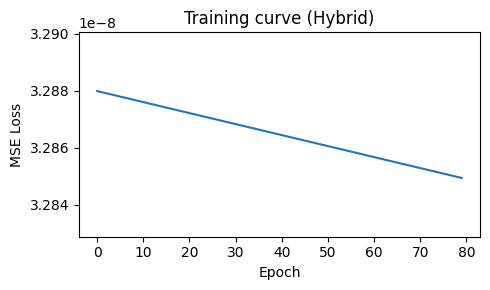

In [9]:
plt.figure(figsize=(5,3))
plt.plot(losses, color='tab:blue')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training curve (Hybrid)')
# zoom if nearly flat
if len(losses) > 5 and (max(losses) - min(losses)) < 1e-2:
    lo, hi = min(losses), max(losses)
    plt.ylim(lo - 0.02 * (hi - lo + 1e-9), hi + 0.02 * (hi - lo + 1e-9))
plt.tight_layout()
plt.show()

### Parity plot (y true vs. y pred) on test set

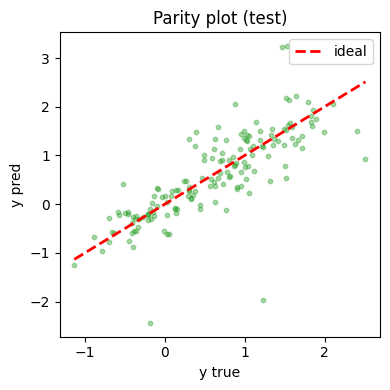

In [10]:
y_pred_test = model_best.predict(X_test)
plt.figure(figsize=(4,4))
plt.scatter(y_test, y_pred_test, s=10, alpha=0.4, color='tab:green')
mn, mx = float(np.min(y_test)), float(np.max(y_test))
plt.plot([mn, mx], [mn, mx], 'r--', lw=2, label='ideal')
plt.xlabel('y true')
plt.ylabel('y pred')
plt.title('Parity plot (test)')
plt.legend()
plt.tight_layout()
plt.show()

### Residuals histogram (test set)

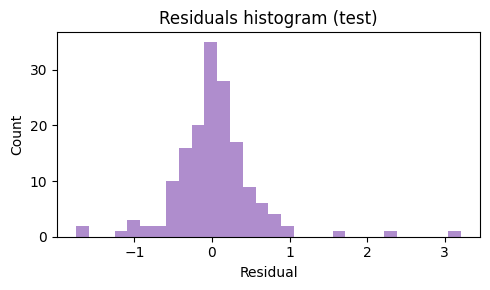

In [11]:
res = (y_test - y_pred_test).ravel()
plt.figure(figsize=(5,3))
plt.hist(res, bins=30, color='tab:purple', alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Count')
plt.title('Residuals histogram (test)')
plt.tight_layout()
plt.show()

## 6) 2D prediction surface (slice)
We fix one feature at its median (from train set) and visualize predictions over a grid for the other two features.

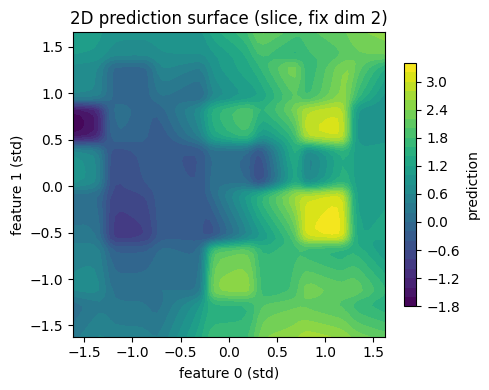

In [12]:
# Choose to vary dimensions 0 and 1; fix dim 2 at its train median
dim_x, dim_y, dim_fix = 0, 1, 2
fixed_val = np.median(X_train[:, dim_fix])

gx = np.linspace(np.percentile(X_train[:, dim_x], 2), np.percentile(X_train[:, dim_x], 98), 60)
gy = np.linspace(np.percentile(X_train[:, dim_y], 2), np.percentile(X_train[:, dim_y], 98), 60)
GX, GY = np.meshgrid(gx, gy)
grid = np.stack([GX.ravel(), GY.ravel(), np.full(GX.size, fixed_val)], axis=1)
Z = model_best.predict(grid).reshape(GX.shape)

plt.figure(figsize=(5,4))
cs = plt.contourf(GX, GY, Z, levels=30, cmap='viridis')
plt.colorbar(cs, shrink=0.8, label='prediction')
plt.xlabel(f'feature {dim_x} (std)')
plt.ylabel(f'feature {dim_y} (std)')
plt.title('2D prediction surface (slice, fix dim 2)')
plt.tight_layout()
plt.show()